In [1]:
import pandas as pd
# I only need first four columns
df = pd.read_csv('Usage data.csv', usecols=[0,1,2,3,4])
# I want to read data from rows 88 to 605
df = df.iloc[86:605]
df.head()

,TimeStamp,ResourceType,ResourceID,Effectiveness,Percentage
86,01-Jan-22,Cloud Storage,Data Scenarios,Cost,30.0
87,02-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0
88,03-Jan-22,Cloud Storage,Data Scenarios,Cost,31.0
89,04-Jan-22,Cloud Storage,Data Scenarios,Cost,37.0
90,05-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0


In [2]:
# Delete column ResourceType, ResourceId, and Effectiveness from the dataframe
df = df.drop(['ResourceType', 'ResourceID', 'Effectiveness'], axis=1)
df.head()

,TimeStamp,Percentage
86,01-Jan-22,30.0
87,02-Jan-22,33.0
88,03-Jan-22,31.0
89,04-Jan-22,37.0
90,05-Jan-22,33.0


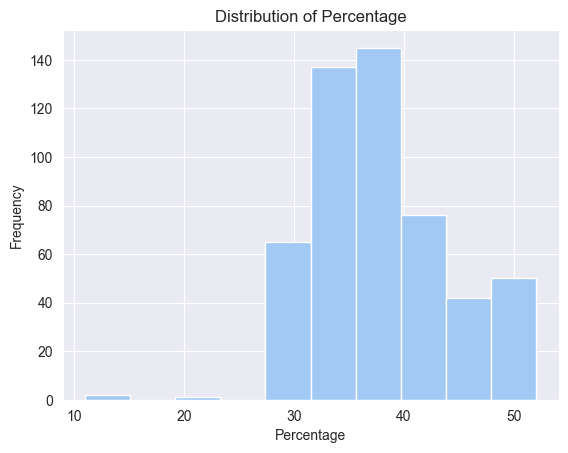

In [3]:
# find distribution of the percentage column using graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('darkgrid')
plt.hist(df['Percentage'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage')
plt.show()

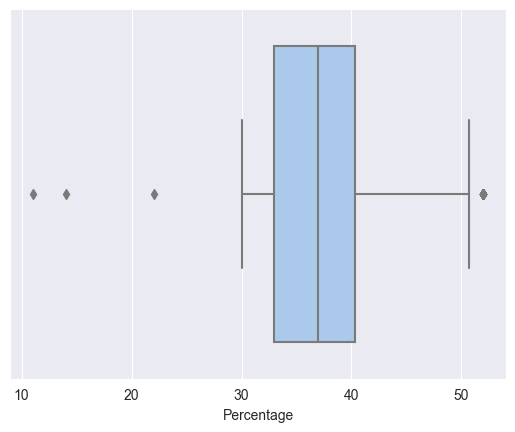

In [4]:
#create a box plot to find outliers
sns.boxplot(x=df['Percentage'])
plt.show()

In [5]:
# convert timestamp column to datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

In [6]:
print(f"starting date : {str(df['TimeStamp'].dt.date.min())}")
print(f"end date : {str(df['TimeStamp'].dt.date.max())}")

starting date : 2022-01-01
end date : 2023-06-02


In [7]:
# Quantile Range
Q1 = df['Percentage'].quantile(0.20)
Q3 = df['Percentage'].quantile(0.80)
IQR = Q3 - Q1

In [8]:
#Calculate number of outliers in a column
((df['Percentage'] < (Q1 - 1.5 * IQR)) | (df['Percentage'] > (Q3 + 1.5 * IQR))).sum()

2

In [9]:
# show the outliers
df['Percentage'][((df['Percentage'] < (Q1 - 1.5 * IQR)) | (df['Percentage'] > (Q3 + 1.5 * IQR)))]

394    11.0
420    14.0
Name: Percentage, dtype: float64

In [10]:
#remove outliers
df = df[~((df['Percentage'] < (Q1 - 1.5 * IQR)) | (df['Percentage'] > (Q3 + 1.5 * IQR)))]
df.shape

(516, 2)

In [11]:
df.head()

,TimeStamp,Percentage
86,2022-01-01,30.0
87,2022-01-02,33.0
88,2022-01-03,31.0
89,2022-01-04,37.0
90,2022-01-05,33.0


In [12]:
import plotly.express as xp
fig = xp.line(df, x='TimeStamp', y='Percentage')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
df.rename(columns={'TimeStamp': 'ds', 'Percentage': 'y'}, inplace=True)
train_data = df.sample(frac=0.8, random_state=10)
validation_data = df.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'validation data size : {validation_data.shape}')

train_data = train_data.reset_index()
validation_data = validation_data.reset_index()

training data size : (413, 2)
validation data size : (103, 2)


In [14]:
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

In [15]:
model = Prophet()
model.fit(train_data)

18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
prediction = model.predict(pd.DataFrame({'ds':validation_data['ds']}))
y_actual = validation_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print(f'Mean Absolute Error : {round(mean_absolute_error(y_actual, y_predicted), 2)}')

Mean Absolute Error : 3.32


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()